In [ ]:
# set up matplotlib
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = [10,5]
import pylab as plt

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

import librosa
import numpy as np
import os
import sys
from random import shuffle

import IPython.display as ipd

# import model code
from model import create_vae_with_elbo_loss

## Define basic global parameters

In [2]:
num_latents = 32

segment_length = 20  # in frames, which is about 200ms
segment_channels = 80

## Helper functions to break to flatten batches and vice-versa

In [3]:
def mel2seg(spec):
    return spec[:len(spec) - len(spec) % segment_length].reshape(-1, segment_length, segment_channels)

def seg2mel(seg):
    return seg.reshape(-1, segment_channels)

def plot_spec(spec):
    plt.imshow(spec[:, ::-1].T)

## Model loaders

In [4]:
def load_beta_vae():
    encoder_units = 256
    decoder_units = 256
    
    segment = tf.placeholder(
        tf.float32, shape=(None, segment_length, segment_channels))

    _, outputs = create_vae_with_elbo_loss(
        segment, segment_channels,
        encoder_units, decoder_units, num_latents, 1.)
    
    return segment, outputs

## Load some test utterance

In [7]:
test_mel = np.load('../obama_hq_2h_trimmed_feat_flat/test/2913.npz')['logmel']

## Build the model in the default tf.Graph

In [6]:
segment, outputs = load_beta_vae()

x_reconst_mean = outputs['x_reconst_mean']
z_posterior_mean = outputs['z_posterior_mean']
z_posterior_sample = outputs['z_posterior_sample']
z_prior = outputs['z_prior']

In [8]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()

## Restore variables from a pretrained checkpoint

In [9]:
saver.restore(sess, './checkpoints/vae_beta_8_atten_2/model.ckpt-199892')

INFO:tensorflow:Restoring parameters from ./checkpoints/vae_beta_8_atten_2/model.ckpt-199892


## Import and load a pretrained mel -> wav inverter

In [10]:
from inverter import Inverter

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)


In [ ]:
inv = Inverter()
inv.init_and_load('./checkpoints/inverter/')

def play_mel(mel):
    w = inv.mel_to_wave(mel)
    return ipd.Audio(data=w, rate=16000)

## Reconstruct the utterance

In [12]:
fd = {segment: mel2seg(test_mel)}

In [13]:
test_mel_pred = seg2mel(sess.run(x_reconst_mean, fd))

## Visualize and play the true and the reconstructed utterances

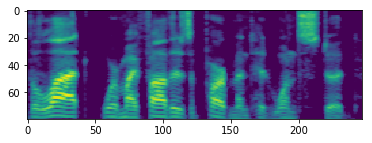

In [14]:
plot_spec(test_mel)

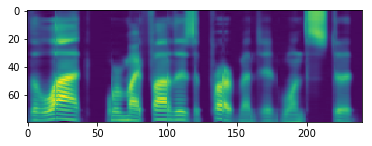

In [15]:
plot_spec(test_mel_pred)

In [16]:
play_mel(test_mel)

In [17]:
play_mel(test_mel_pred)

## Helper function to vary single code variable

In [18]:
def modify_code(seed, variable_id, steps=np.linspace(-3, 3, 10), mode='replace'):
    insegs = mel2seg(seed)
    fd = {segment: insegs}
    z_post_ = sess.run(z_posterior_mean, fd)
    z_post_range_ = np.tile(z_post_, [len(steps), 1])
    
    if mode == 'replace':
        z_post_range_[:, variable_id] = np.repeat(steps, z_post_.shape[0])
    elif mode == 'add':
        z_post_range_[:, variable_id] += np.repeat(steps, z_post_.shape[0])
    else:
        raise Exception('Unknown mode')
        
    fd = {segment: np.tile(insegs, [len(steps), 1, 1]), z_posterior_sample: z_post_range_}
    segs = sess.run(x_reconst_mean, fd)
    mel = seg2mel(segs)
    return mel

## Helper function to generate samples from prior

In [19]:
def dream(frames):
    z_prior_ = sess.run(z_prior, {segment: np.ones((frames, 20, 80)) * 1000})
    segs = sess.run(x_reconst_mean, {z_posterior_sample: z_prior_, segment: np.ones((frames, 20, 80)) * 1000})
    return seg2mel(segs)

## Let's vary each variable given a seed segment (part of a syllable)

In [20]:
seed = test_mel[18:38]

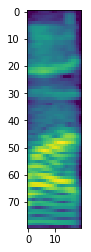

In [21]:
plot_spec(seed)

Code #0


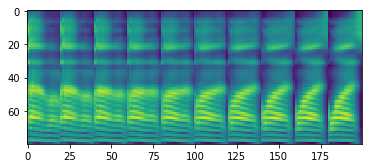

Code #1


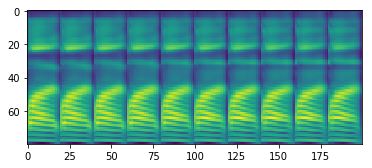

Code #2


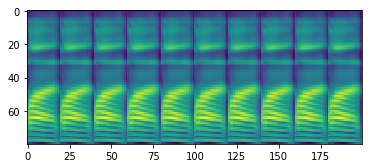

Code #3


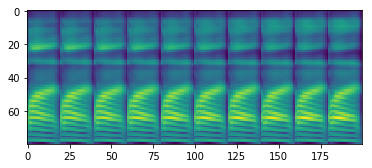

Code #4


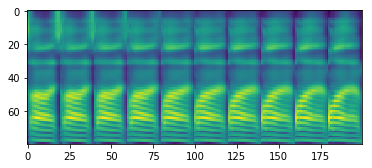

Code #5


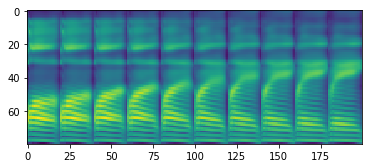

Code #6


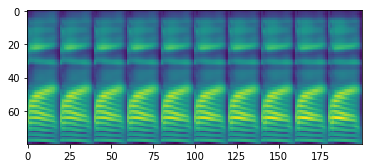

Code #7


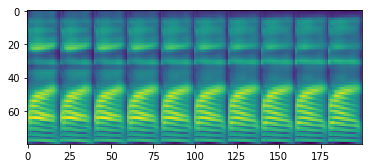

Code #8


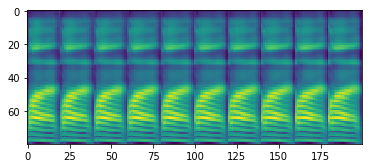

Code #9


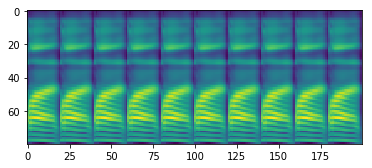

Code #10


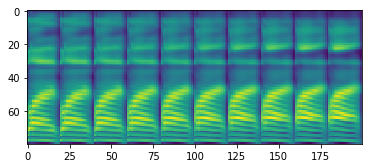

Code #11


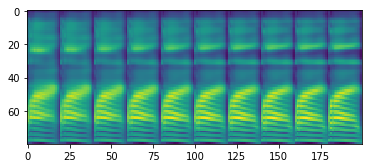

Code #12


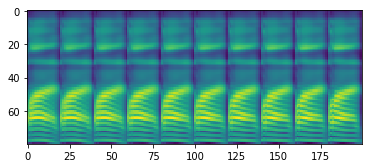

Code #13


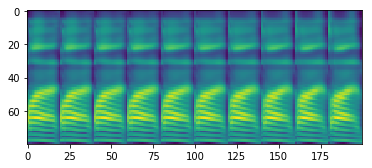

Code #14


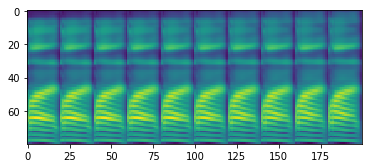

Code #15


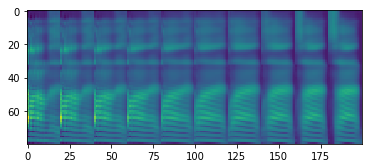

Code #16


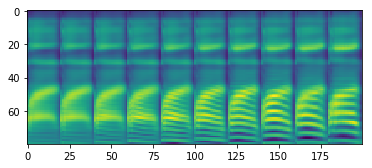

Code #17


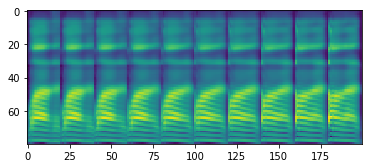

Code #18


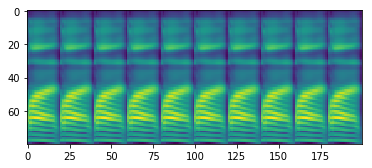

Code #19


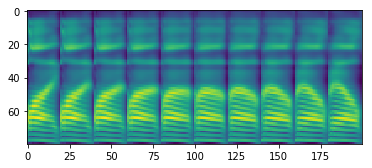

Code #20


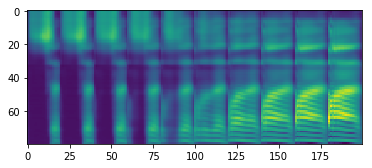

Code #21


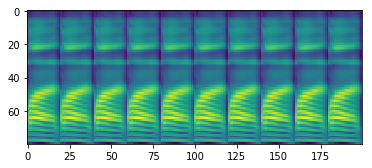

Code #22


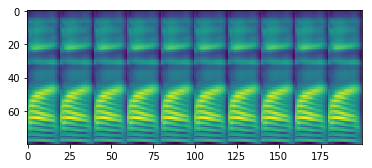

Code #23


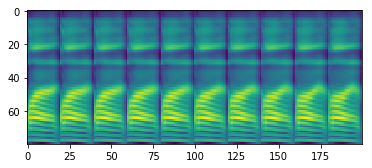

Code #24


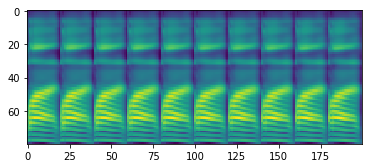

Code #25


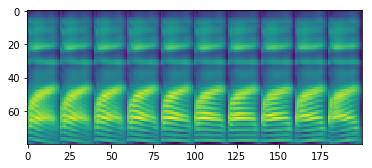

Code #26


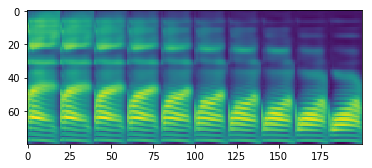

Code #27


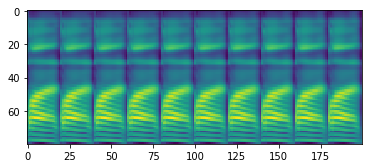

Code #28


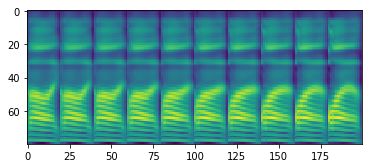

Code #29


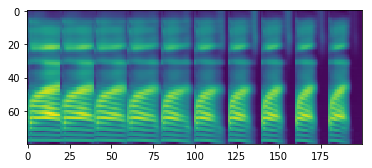

Code #30


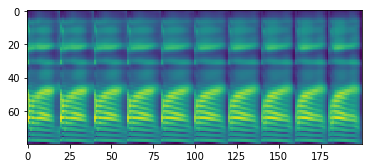

Code #31


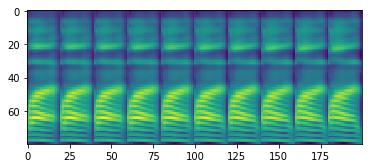

In [22]:
for i in range(32):
    print("Code #{}".format(i))
    mel = modify_code(seed, i)
    plot_spec(mel)
    plt.show()
    
    au = inv.mel_to_wave(mel)
    ipd.display(ipd.Audio(data=au, rate=16000))

## Now let's additively perturb one code variable of a whole sequence with different constants

In [23]:
def modify_code_sequence(mel, code, steps=np.linspace(-3, 3, 10)):
    batch = modify_code(test_mel, code, steps, mode='add')
    seq_length = batch.shape[0] // len(steps)
    return [batch[i * seq_length: (i + 1) * seq_length] for i in range(len(steps))]

In [24]:
mels = modify_code_sequence(test_mel, 16)

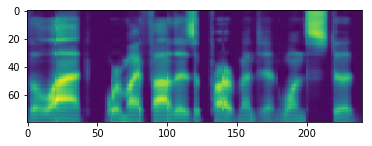

In [25]:
plot_spec(mels[0])

In [26]:
for mel in mels:
    au = inv.mel_to_wave(mel)
    ipd.display(ipd.Audio(data=au, rate=16000))

## Finally, we can generate some segments from the prior distribution p(z)

In [27]:
dream_mel = dream(50)

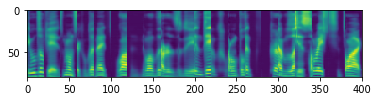

In [28]:
plot_spec(dream_mel[:400])

In [29]:
play_mel(dream_mel)

## Posteriors are separated

In [30]:
codes_post = np.vstack([sess.run(z_posterior_sample, {segment: [seed]}) for i in range(1000)])

In [31]:
codes_post2 = np.vstack([sess.run(z_posterior_sample, {segment: [test_mel[0:20]]}) for i in range(1000)])

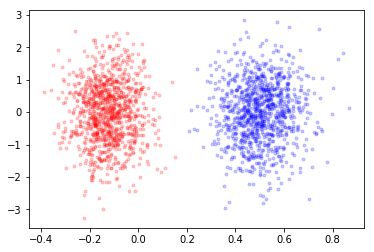

In [32]:
plt.plot(codes_post[:, 0], codes_post[:, 2], 'b.', alpha=0.2)
plt.plot(codes_post2[:, 0], codes_post2[:, 2], 'r.', alpha=0.2)

## Sampling from posterior

In [33]:
mel_sample_segs = sess.run(
    x_reconst_mean,
    {z_posterior_sample: codes_post[:20], segment: np.ones((20, 20, 80))})

In [34]:
mel_samples = seg2mel(mel_sample_segs)

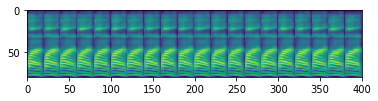

In [35]:
plot_spec(mel_samples)

In [36]:
play_mel(mel_samples)

## Latent space traversal

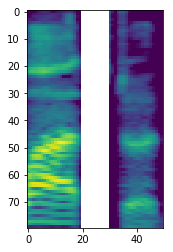

In [37]:
seed2 = test_mel[215:235]
plot_spec(np.vstack((seed, np.nan * np.ones((10, 80)), seed2)))

In [38]:
code = sess.run(z_posterior_mean, {segment: [seed ]})
code2 = sess.run(z_posterior_mean, {segment: [seed2]})

In [39]:
alpha_code = np.linspace(0, 1, 20)[:, None]
alpha_seed = alpha_code[:, :, None]
codes_interp = alpha_code * code + (1 - alpha_code) * code2
seed_interp = alpha_seed * seed + (1 - alpha_seed) * seed2

In [40]:
segs_code = sess.run(x_reconst_mean, {z_posterior_sample: codes_interp, segment: np.ones((20, 20, 80))})
mel_code = seg2mel(segs_code)
mel_seed = seg2mel(seed_interp)

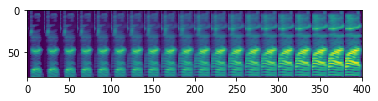

In [41]:
plot_spec(mel_seed)

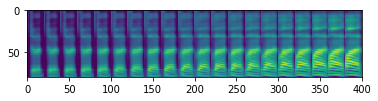

In [42]:
plot_spec(mel_code)

In [43]:
play_mel(mel_seed)

In [44]:
play_mel(mel_code)